<a href="https://colab.research.google.com/github/nyp-sit/agods/blob/main/day5/solutions/5.final_exercise_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/agods/nyp_ago_logo.png" width='400'/>

# Final Exercise: Regression Model

We will build a Linear regression model for Medical cost dataset. The dataset consists of age, sex, BMI, children, smoker and region feature, which are independent and charge as a dependent feature. We will predict individual medical costs billed by health insurance.

### Import Library and Dataset
Now we will import couple of python library required for our analysis and import dataset 

In [1]:
# Import library
import pandas  as pd  
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns  

In [2]:
# Import dataset
df = pd.read_csv('../data/insurance.csv')

### Task 1: Check for missing values 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Task 2: Check the distribution of the variables

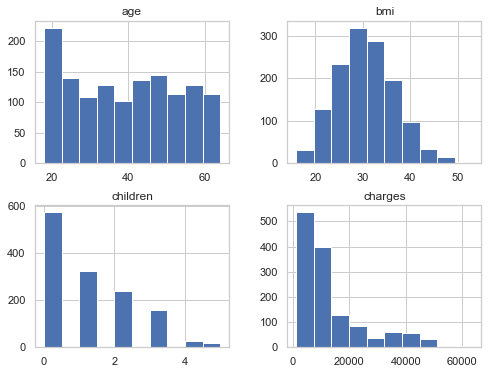

In [5]:
sns.set_theme(style='whitegrid')
df.hist(figsize=(8,6))
plt.show()

### Task 3: Splitting Data into Train and Test Set

Assuming we think age is key for good prediction, we want to preserve the same age distribution in our train and test samples.

1. Bin the age into appropriate number the following bins \[0, 25\], \[25, 35\], \[35, 45\], \[45, 55\] and \[55, $\infty$\]. 
2. Create a new column named 'age_cat' for the age categories. 
3. split the data into train test split, with 80:20 split, and with strafitied splitting on 'age_cat'

In [6]:
df["age_cat"] = pd.cut(df["age"],
                          bins=[0, 25, 35, 45, 55, np.inf],
                          labels=[1, 2, 3, 4, 5])
df["age_cat"].value_counts().sort_index()

1    306
2    268
3    264
4    284
5    216
Name: age_cat, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split 

strat_train_set, strat_test_set = train_test_split(df, shuffle=True, 
                                                   train_size=0.8,
                                                   stratify=df['age_cat'], 
                                                   random_state=42)

In [8]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 486 to 616
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1070 non-null   int64   
 1   sex       1070 non-null   object  
 2   bmi       1070 non-null   float64 
 3   children  1070 non-null   int64   
 4   smoker    1070 non-null   object  
 5   region    1070 non-null   object  
 6   charges   1070 non-null   float64 
 7   age_cat   1070 non-null   category
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 68.1+ KB


### Task 4: Look for correlation

In [9]:
# correlation plot
corr_matrix = strat_train_set.corr()
corr_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.285159
bmi         0.233447
children    0.052562
Name: charges, dtype: float64

Thier no correlation among valiables.

### Task 5: Separate features and labels

In [10]:
insurance = strat_train_set.drop('charges', axis=1)
insurance_labels = strat_train_set['charges']

### Task 6: Separate the numerical features from categorical features

We have a few categorical features that we need to one-hot-encode. We also need to do scaling on the numerical features.  We want to build different transformation pipeline for these two different types of data.  So you need to first separate numerical features from categorical features. Call your new dataframes as `insurance_num` and `insurance_cat`.

In [11]:
categorical_columns = ['sex','smoker', 'region', 'age_cat']
insurance_num = insurance.drop(categorical_columns, axis=1)
insurance_cat = insurance[categorical_columns]

### Task 7: Build a pipeline for numerical data

Build a pipeline to do scaling for numerica data, using StandardScaler. It is also good practice to include imputer. Although we don't have any missing data in the training data (and test data), we cannot guarantee that there won't be any missing values during the live system (e.g. users may leave certain data blank).

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

### Task 8: Build a pipeline for categorical data 

Build pipeline to one-hot-encode categorical features. You need to specify sparse_output to False, so the return values will not be a sparse matrix, which make converting the output back to Dataframe difficult.

In [13]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))

### Task 9: Build a single combined pipeline

In [14]:
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

num_attribs = ["age", "bmi", "children"] 
cat_attribs = ['sex', 'smoker', 'region','age_cat']

# preprocessing = make_column_transformer(
#                     (num_pipeline, num_attribs), 
#                     (cat_pipeline, cat_attribs))
# preprocessing

from sklearn.compose import make_column_selector 

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

preprocessing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000221EECC3430>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000221EECC3220>)])

### Task 10: Select a model and evaluate the model using cross validation

Choose a scoring function, `r2` to cross validate your model.

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
linreg_score = cross_validate(lin_reg, 
                              insurance, 
                              insurance_labels,
                              scoring="r2", 
                              return_train_score=True,
                              cv=5)

print("r2 (train): ", linreg_score['train_score'])
print("average train r2: ", linreg_score['train_score'].mean())
print("r2 (val):", linreg_score['test_score'])
print("average val r2:", linreg_score['test_score'].mean())

r2 (train):  [0.76650471 0.74961607 0.75969089 0.77264848 0.76697348]
average train r2:  0.763086724149329
r2 (val): [0.7195992  0.79668269 0.76986306 0.71908636 0.73702571]
average val r2: 0.7484514065434155


### Task 11: Evaluate final model on test data

In [16]:
final_model = make_pipeline(preprocessing, LinearRegression())
final_model.fit(insurance, insurance_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000221EECC3430>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000221EECC3220>)])),
                ('linearregression', LinearRegression())])

In [17]:
from sklearn.metrics import r2_score

X_test = strat_test_set.drop("charges", axis=1)
y_test = strat_test_set["charges"]

final_predictions = final_model.predict(X_test)
final_r2 = r2_score(y_test, final_predictions)
print(final_r2) 

0.6607779110354637
